<p><b>Predição preço de ações utilizando LSTM.</b></p>

#### Redes Neurais

https://pathmind.com/wiki/neural-network


 #### LSTM

https://pathmind.com/wiki/lstm#recurrent

#### Construção da LSTM

In [1]:
#Bibliotecas para manipulação dos dados
import pandas as pd
import numpy as np
from datetime import datetime

#Bibliotecas de gráfico
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
plt.style.use('ggplot')

#Bibliotecas para construímos a LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, LeakyReLU
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from functions import get_finance_data

#Biblioteca para retirar avisos
import warnings
warnings.filterwarnings("ignore")

#### Tratamento de Dados

In [28]:
#Leitura dos dados
# dados=pd.read_csv("Apple_stocks.csv",sep=",")

In [26]:
dados = get_finance_data("VALE3.SA", period='3y')

In [27]:
#Conhecendo os dados que iremos trabalhar
df.head()

Date
2019-12-30    51.161327
2020-01-02    52.150002
2020-01-03    51.766048
2020-01-06    51.458889
2020-01-07    51.833241
Name: Close, dtype: float64

In [7]:
dados.dtypes

Open            float64
High            float64
Low             float64
Close           float64
Volume            int64
Dividends       float64
Stock Splits      int64
dtype: object

<p> Podemos observar que nossos dados não estão em um formato que podem ser utilizados em uma LSTM, pois por padrão as sequências de dados de <i>input</i> devem ser numéricos.</p>
<p>Além disso, a coluna <i>Date</i> está com um formato diferente do desejável para construírmos nossa Série Temporal.<p>


In [8]:
#Vamos criar uma cópia dos dados originais para podermos manipular os dados.
df = dados.copy()

In [ ]:
#Renomeando as colunas
# df.columns = ["Date","Close","Volume","Open","High","Low"]

O objetivo da nossa LSTM vai ser prever o preço de fechamento da ação, com isso precisamos transformar os dados da coluna <i><b>Close</b></i> de <i>object</i> para <i>float</i>.

In [ ]:
# #Definindo a função para alteramos as datas
# def to_string_date(x:str):
#     return pd.to_datetime(
#                         datetime.strftime(
#                             datetime.strptime(x.replace("/","-"),"%m-%d-%Y"),"%Y-%m-%d"))

# #Definindo a função para alteramos o valor de fechamento
# def to_float(x:str):
#     return float(x[x.find("$")+1:])

# #Aplicamos as funções nas colunas que precisam de transformação
# df["Date"] = df["Date"].apply(to_string_date)
# df["Close"] = df["Close"].apply(to_float)
# df = df.sort_values('Date')

<p>Agora que fizemos o tratamento das colunas que iremos utilizar, precisamos colocar nossos dados no formato de uma Série Temporal.</p>


In [9]:
# df.index = df["Date"]
df = df["Close"]

<p>Após criada nossa Série, vamos fazer um plot dos dados.</p>

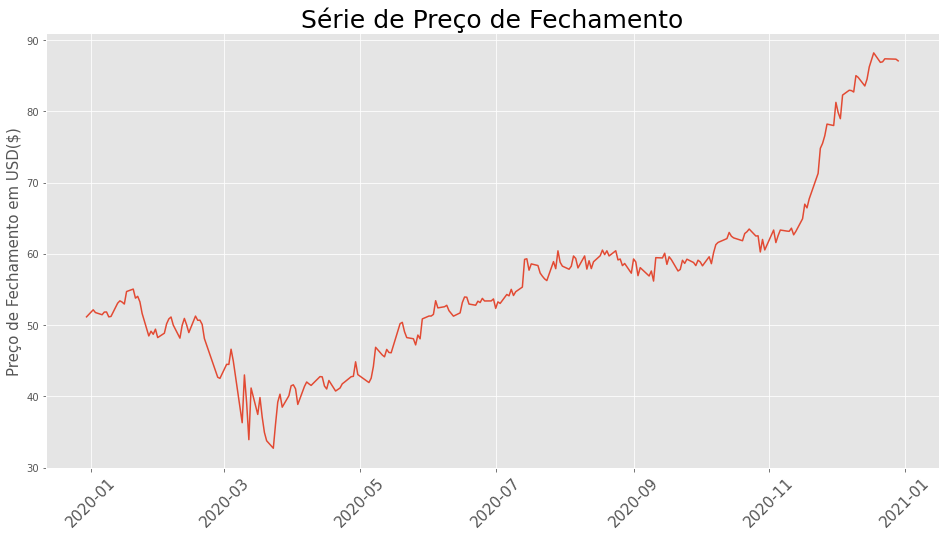

In [10]:
#Vamos analisar o comportamento da nossa variável resposta
plt.figure(figsize=(16,8))
plt.ylabel("Preço de Fechamento em USD($)",fontsize=15)
plt.title('Série de Preço de Fechamento',fontsize=25)
plt.xticks(rotation= 45,fontsize=15)
plt.plot(df)

<p>Ao analisarmos o gráfico podemos perceber uma tedência na nossa série, além de uma grande discrepância entre os valores observados. </p>
<p>Para solucionarmos o problema da diferença entre os valores, vamos usar uma técnica de normalização.</p>

In [11]:
dataset = df.values.reshape((-1,1))
scaler = MinMaxScaler(feature_range=(0, 1)) 
dataset = scaler.fit_transform(dataset)

<p>Antes de iniciarmos o processo de modelagem propriamente dito, temos que decidir quantas observações do passado vamos utilizar para estimarmos o valor futuro.</p>
<p>Além disso, temos que decidir quantos passos à frente vamos querer estimar.</p>

In [12]:
'''Para treinar nossa rede, usaremos um intervalo de tempo para prevermos o nosso próximo valor'''
look_back = 5
future_target = 1

<p>Então, seguindo o processo de modelagem, vamos separar nossos dados em dados de treino e teste. Nesse caso, vamos usar 70% dos dados como dados de teste.</p>

In [13]:
'''Separando os dados em treino e teste.'''
tam = int(len(dataset) * 0.70)
dataset_teste = dataset[tam:]
dataset_treino = dataset[:tam]

In [20]:
tam

172

<p>Por padrão, Redes Neurais necessitam que os dados de <i>input</i> estejam na forma matricial, de preferência uma matriz tridimensional.<p>

In [14]:
#Função de transformação dos dados
def process_data(data, look_back, forward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)


In [15]:
X, y = process_data(dataset_treino,look_back,future_target)
y = np.array([list(a.ravel()) for a in y])

x_test, y_test = process_data(dataset_teste,look_back,future_target)
y_test = np.array([list(a.ravel()) for a in y_test])

<p>Realizamos esse processo para permitir que a rede possa identificar que cada conjunto de valores de X_train gere o valor de y_train, ou seja, o input x_train[0] gera o output y_train[0] e assim sussecivamente.<p>

In [17]:
y[0]

array([0.34460337])

<p>Agora, vamos separar nosso conjunto de dados de teste e separar um porcentagem para validação.</p>

In [21]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42)

<p>No próximo passo vamos contruir a rede neural propriamente dita.</p>
<p>Iremos usar alguns paramêtros padrões, pois o processo de tunning dos parâmetros é um processo que exige testes e investigações mais profundas sobre os dados.</p>

In [22]:
#Definindo os números de neurônios por camada
n_first = 128
EPOCHS = 50
#Construido o modelo
model = Sequential()
model.add(LSTM(n_first,input_shape = (look_back,1)))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=False,batch_size=2, verbose=2)

Epoch 1/50
67/67 - 2s - loss: 0.0148 - val_loss: 0.0012
Epoch 2/50
67/67 - 0s - loss: 0.0033 - val_loss: 0.0010
Epoch 3/50
67/67 - 0s - loss: 0.0027 - val_loss: 8.2806e-04
Epoch 4/50
67/67 - 0s - loss: 0.0028 - val_loss: 0.0012
Epoch 5/50
67/67 - 0s - loss: 0.0027 - val_loss: 7.9492e-04
Epoch 6/50
67/67 - 0s - loss: 0.0027 - val_loss: 8.5920e-04
Epoch 7/50
67/67 - 0s - loss: 0.0027 - val_loss: 0.0014
Epoch 8/50
67/67 - 0s - loss: 0.0027 - val_loss: 9.9166e-04
Epoch 9/50
67/67 - 0s - loss: 0.0026 - val_loss: 0.0011
Epoch 10/50
67/67 - 0s - loss: 0.0022 - val_loss: 7.6770e-04
Epoch 11/50
67/67 - 0s - loss: 0.0026 - val_loss: 7.6950e-04
Epoch 12/50
67/67 - 0s - loss: 0.0022 - val_loss: 8.1327e-04
Epoch 13/50
67/67 - 0s - loss: 0.0020 - val_loss: 7.6729e-04
Epoch 14/50
67/67 - 0s - loss: 0.0023 - val_loss: 9.8815e-04
Epoch 15/50
67/67 - 0s - loss: 0.0019 - val_loss: 6.8270e-04
Epoch 16/50
67/67 - 0s - loss: 0.0024 - val_loss: 8.6910e-04
Epoch 17/50
67/67 - 0s - loss: 0.0022 - val_loss: 7.1

<p>Em seguida, usamos nosso modelo escolhido para seguirmos para o processo de predição.</p>

<p>Após o treinamento do nosso modelo, podemos verificar o comportamento da função custo nos dados de validação e nos dados de teste.</p>
<p>A análise do comportamento das curvas podem ser usados como indicador de <i>underfitting</i> ou <i>overfitting</i>.</p>

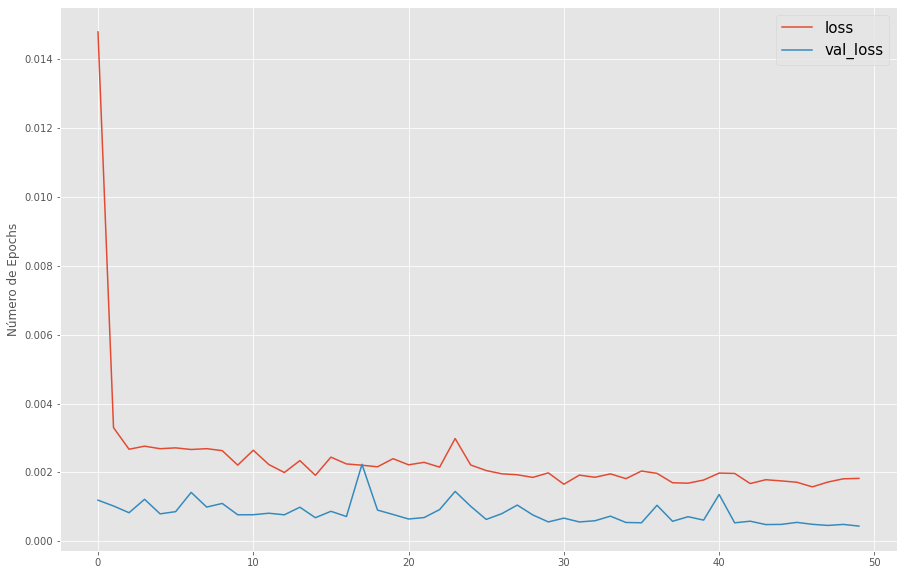

In [23]:
#Gráfico do resultado da função perda por epochs
plt.figure(figsize = (15,10))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel("Número de Epochs")
plt.legend(loc='best',fontsize=15)
plt.show()

In [24]:
#Salvando os valores preditos
Xt = model.predict(x_test)

<p>Por fim, podemos identificar o comportamento do nosso modelo na série.</p>
<p>Podemos observar que nosso modelo se comportou bem diante das configurações que escolhemos.</p>

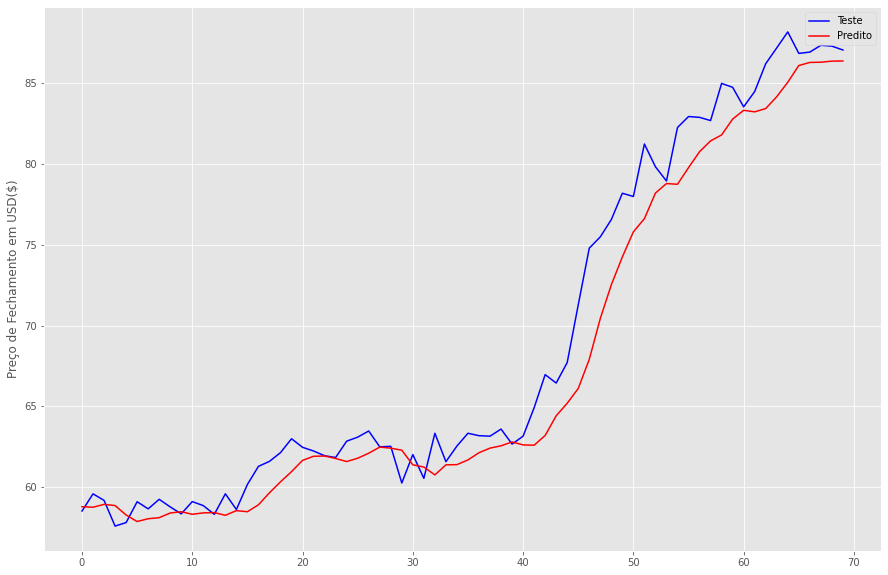

In [25]:
plt.figure(figsize = (15,10))
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)),c='b', label='Teste')
plt.plot(scaler.inverse_transform(Xt.reshape(-1,1)), c='r',label='Predito')
plt.ylabel("Preço de Fechamento em USD($)")
plt.legend(loc='best')
plt.show()

In [29]:
Xt

array([[0.46992114],
       [0.4693539 ],
       [0.47250658],
       [0.47120216],
       [0.4606608 ],
       [0.45338118],
       [0.45648435],
       [0.45767984],
       [0.46290046],
       [0.46428767],
       [0.46146998],
       [0.46302384],
       [0.46334612],
       [0.46032858],
       [0.4655496 ],
       [0.46431383],
       [0.47202307],
       [0.48545316],
       [0.49768066],
       [0.5090601 ],
       [0.52163714],
       [0.52622604],
       [0.5265127 ],
       [0.5237713 ],
       [0.52033   ],
       [0.52404714],
       [0.52963126],
       [0.53646934],
       [0.5352746 ],
       [0.5330243 ],
       [0.5166949 ],
       [0.51419455],
       [0.50543225],
       [0.516674  ],
       [0.51688766],
       [0.5221443 ],
       [0.5302005 ],
       [0.5353269 ],
       [0.53790486],
       [0.54221535],
       [0.5389257 ],
       [0.5385683 ],
       [0.5494368 ],
       [0.5714049 ],
       [0.5854324 ],
       [0.6019486 ],
       [0.63440275],
       [0.680

#### Próximos passos

<p>Vimos que treinar uma Rede Neural não é uma tarefa de outro mundo, contudo exige conhecimento e prática para aperfeiçoar a rede.</p>
